In [482]:
import sys
sys.path.append('/home/joaoc/SimulaCorona/.env/lib/python3.6/site-packages/')

import pandas as pd
import numpy as np
import plotly.express as px
import yaml
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as md
from tqdm import tqdm

from paths import *

%reload_ext autoreload
%autoreload 2

from datetime import datetime
date_time = datetime.today().strftime('%Y-%m-%d-%H-%M')


In [483]:
def decide_scenario(c2, c3):
    
    if c2 < c3:
        return 'isolation'
    elif c2 >= c3:
        return 'lockdown'
    elif c2 == 0:
        return 'nothing'
    
def update_param(parameters, days, c2, c3):


    for v in config['scenarios'][decide_scenario(c2, c3)]['R0'].values():
        param['R0'] = v
        parameters.append(deepcopy(param))

In [484]:
def load_data():
    
    df_cases_covid19br = get_data.city_cases_covid19br(config['get_data_paths']['cases_covid19br'])
    df_cases_brasilio = get_data.city_cases_brasilio(config['get_data_paths']['cases_brasilio'])

    df_cases_covid19br = clean_data.treat_covid19br(config['raw_paths']['cases_covid19br'], config['treated_paths']['cases_covid19br'])
    df_cases_brasilio = clean_data.treat_brasilio(config['raw_paths']['cases_brasilio'], config['treated_paths']['cases_brasilio']) 

    df_sus = clean_data.treat_sus(config['raw_paths']['sus'], config['treated_paths']['sus'])

    to_gbq(df_cases_brasilio, 'brasilio_cases', if_exists='replace')
    to_gbq(df_sus, 'sus_capacity', if_exists='replace')

    df = pd.merge(df_cases_brasilio, df_sus, how='left', on='region_id')
    
    
    
    return df

In [776]:
def run_model_sequntial(df_city):
    
    final = pd.DataFrame()
    region_id = df_city['region_id'].iloc[0]
    for c2 in config['scenarios']['isolation']['dates']:
        for c3 in config['scenarios']['lockdown']['dates']:
            for bound in ['lower_bound', 'upper_bound']:

                model_params = {k: v[bound] 
                                for k, v in config['model_parameters']['seir'].items()}

                model_params.update(
                    {'days_from_t0': min(c2, c3),
                     'scenario': 'nothing',
                     'R0': config['scenarios']['nothing']['R0'][bound],
                     'i2_percentage': model_params['i2_percentage'] * model_params['notification_rate'],
                     'i3_percentage': model_params['i3_percentage'] * model_params['notification_rate']
                    })
                
                current_infected = df_city['confirmed_inputed'].values[0] / model_params['notification_rate']
                exposed = current_infected * model_params['doubling_rate'] / model_params['sigma']
                
                current_state = {
                    'population': df_city['populacao'].values[0] ,
                    'exposed': exposed,
                    'current_infected': current_infected,
                    'suceptible': df_city['populacao'].values[0] \
                                  - current_infected \
                                  - exposed,
                    'recovered': 0
                }
                

                res = seir.entrypoint(current_state, 
                                     model_params)
                
                model_params.update(
                    {'days_from_t0': max(c2, c3) - min(c2, c3),
                     'scenario': decide_scenario(c2, c3),
                     'R0': config['scenarios'][decide_scenario(c2, c3)]['R0'][bound]
                    })
                
                current_state['suceptible'] = res['S'].iloc[-1]
                current_state['exposed'] = res['E'].iloc[-1]
                current_state['current_infected'] = res['I'].iloc[-1]
                current_state['recovered'] = res['R'].iloc[-1]

                res = pd.concat([res, seir.entrypoint(current_state, 
                                                      model_params)[1:]])

                model_params.update(
                        {'days_from_t0': config['estimation_days'] - max(c2, c3),
                         'scenario': decide_scenario(c3, c2),
                         'R0': config['scenarios'][decide_scenario(c3, c2)]['R0'][bound]
                        })
                
                current_state['suceptible'] = res['S'].iloc[-1]
                current_state['exposed'] = res['E'].iloc[-1]
                current_state['current_infected'] = res['I'].iloc[-1]
                current_state['recovered'] = res['R'].iloc[-1]


                res = pd.concat([res, seir.entrypoint(
                                                 current_state, 
                                                 model_params)[1:]])


                res = res.reset_index(drop=True).reset_index()\
                      .drop('days', 1).rename(columns={'index': 'days'})
                res['isolation_t'] = c2
                res['lockdown_t'] = c3
                res['bound'] = bound
                res['region_id'] = region_id
                
                final = pd.concat([final, res])
            
    final = final.pivot_table(index=['region_id', 'isolation_t', 'lockdown_t', 'days'], 
                      columns='bound', 
                      values=['I1', 'I2', 'I3', 'S', 'I', 'R', 'E'])

    final.columns = ['_'.join(col).strip() for col in final.columns.values]
    final = final.reset_index()
    final = final.merge(df_city[['region_id', 'quantidade_leitos', 'ventiladores_existentes',
                            'city_name', 'state', 'sus_region_name']], on='region_id')
    
    convert_dict = {
                'region_id': str,
                'isolation_t': int,
                'lockdown_t': int,
                'days': int,
                'E_lower_bound': float,
                'E_upper_bound': float,
                'I_lower_bound': float,
                'I_upper_bound': float,
                'I1_lower_bound': float,
                'I1_upper_bound': float,
                'I2_lower_bound': float,
                'I2_upper_bound': float,
                'I3_lower_bound': float,
                'I3_upper_bound': float,
                'R_lower_bound': float,
                'R_upper_bound': float,
                'S_lower_bound': float,
                'S_upper_bound': float,
                'quantidade_leitos': float,
                'ventiladores_existentes': float,
                'city_name': str,
                'state': str,
                'sus_region_name': str,
               } 

    final = final.astype(convert_dict) 
    
    io.upload_data(final,
                   'model_evolution', 
                   {'region_id': region_id},
                   region_id,
                   config
                  )
    io.create_table('model_evolution', config, partition=True)
    return final


In [777]:
config = yaml.load(open('../configs/config.yaml', 'r'))

In [778]:
region_id = 'SE_ARACAJU'

In [779]:
final = run_model_sequntial(df.query(f'region_id == "{region_id}"'))

In [781]:
_run_limits(region_id)
io.create_table('best_case', config, partition=True)
io.create_table('worst_case', config, partition=True)
for r in config['resources']:
    io.create_table(f'dday_{r["resource"]}_filter', config, partition=True)

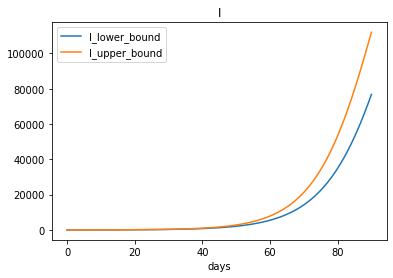

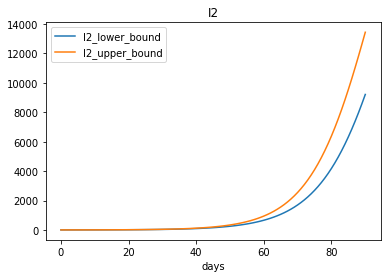

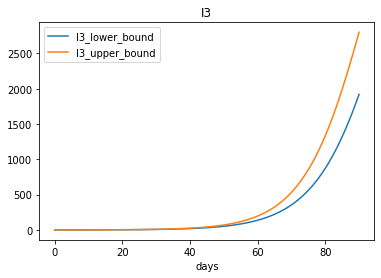

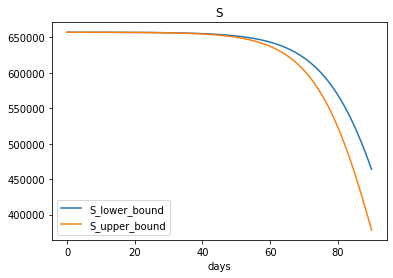

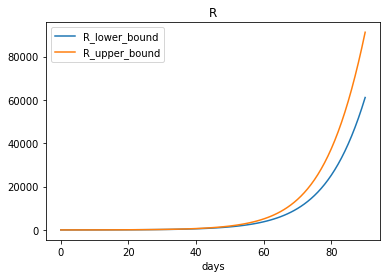

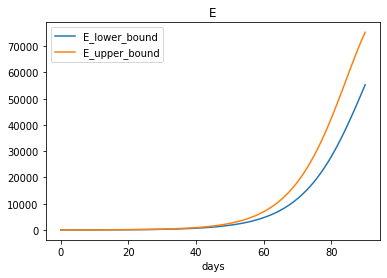

In [780]:
for t in ['I','I2', 'I3', 'S', 'R', 'E']:
    ax = final.query('isolation_t == 90').query('lockdown_t == 90')\
    .set_index('days')[[f'{t}_lower_bound', f'{t}_upper_bound']]\
    .plot( title=t)

In [486]:
from src.models import seir
from src import io
from multiprocessing.pool import Pool
from functools import partial
import time

In [487]:
def pivot_to(_df, key):
    a = _df.pivot_table(index='variation_perc', columns='resource', values=key, dropna=False)
    return a.rename(columns={c: key + '_' + c for c in a.columns})

def get_limits(_df):
    
    d = []
    for arg in config['resources']:
        for variation_perc in arg['variation_perc']:
            for bound in ['lower', 'upper']:
                
                var = variation_perc / 100
                n_resource = int(_df[arg['resource']].iloc[0] * var)
                
                day = _df[n_resource < _df[f'{arg["infected"]}_{bound}_bound']]\
                        .sort_values(by='days').head(1)
                
                if len(day):
                    dday = day['days'].values[0]
                else:
                    dday = np.nan
                    
                res = {}    
                res['resource'] = f'{arg["resource"]}_{bound}'
                res['dday'] =  dday
                res['variation_perc'] = variation_perc
                res['number'] = n_resource
                
                d.append(res)
    d = pd.DataFrame(d)
    return pd.concat([pivot_to(d, 'dday'), pivot_to(d, 'number')], 1)

In [488]:
def _run_limits(region_id):

    table = (f"{config['gcloud']['bigquery']['project_id']}"
         f".{config['gcloud']['bigquery']['schema']['prod']}"
          ".model_evolution")

    final = io.read_gbq(
        f"select * from `{table}` where region_id = '{region_id}'",
        progress_bar_type=None)

    dday = final.groupby(['region_id', 'isolation_t', 'lockdown_t'])\
            .apply(get_limits).reset_index()

    dday = dday.merge(df[['region_id', 'city_name', 'state', 'sus_region_name']], 
                      on='region_id')

    convert_dict = {'region_id': str,
                    'isolation_t': int,
                    'lockdown_t': int,
                    'variation_perc': int,
                    'city_name': str,
                    'state': str,
                    'sus_region_name': str,
                    'dday_quantidade_leitos_lower': float,
                    'dday_quantidade_leitos_upper': float,
                    'number_quantidade_leitos_lower': float,
                    'number_quantidade_leitos_upper': float,
                    'dday_ventiladores_existentes_lower': float,
                    'dday_ventiladores_existentes_upper': float,
                    'number_ventiladores_existentes_lower': float,
                    'number_ventiladores_existentes_upper': float
                   } 

    dday = dday.astype(convert_dict) 
    
    
    best_case = dday.query('lockdown_t == 1')\
                .query('isolation_t == 60')\
                .query('variation_perc == 20')\
                .drop(['lockdown_t', 'isolation_t'], 1)
    worst_case = dday.query('lockdown_t == 60')\
                .query('isolation_t == 60')\
                .query('variation_perc == 20')\
                .drop(['lockdown_t', 'isolation_t'], 1)
                
    io.upload_data(best_case, 
               'best_case',
                {'region_id': region_id},
                region_id,
                config
               )

    io.upload_data(worst_case, 
               'worst_case',
                {'region_id': region_id},
                region_id,
                config
               )

    keep = ['region_id', 'isolation_t', 'lockdown_t', 
            'variation_perc',  'city_name', 'state', 'sus_region_name']
    for r in config['resources']:
        temp = dday[keep + [c for c in dday.columns if r['resource'] in c]]
        temp = temp.rename(columns={'variation_perc': f'variation_perc_{r["resource"]}'})
        io.upload_data(
                temp,
                f'dday_{r["resource"]}_filter',
                {'region_id': region_id},
                region_id,
                config
        )

In [489]:
def run_projections(df, region_ids, config):

    # Fixed Extra Variable
    times = [df.query(f"region_id == '{region_id}'")
             for region_id in region_ids]

    with Pool(config['number_of_threads']) as p:
        p.map(run_model_sequntial, times)
        
    io.create_table('model_evolution', config, partition=True)

In [490]:
def run_limits(region_ids, config):

    with Pool(config['number_of_threads']) as p:
        p.map(_run_limits, region_ids)
    
    io.create_table('best_case', config, partition=True)
    io.create_table('worst_case', config, partition=True)
    for r in config['resources']:
        io.create_table(f'dday_{r["resource"]}_filter', config, partition=True)

In [651]:
config = yaml.load(open('../configs/config.yaml', 'r'))

In [652]:
import time

In [782]:
df = get_data.load_data(config)

Downloading: 100%|██████████| 5566/5566 [00:00<00:00, 19333.26rows/s]
1it [00:03,  3.12s/it]


In [783]:
break_list_in_chuncks = lambda data, chunck: [data[x:x+chunck] for x in range(0, len(data), chunck)]

In [784]:
region_ids = list(df['region_id'])

In [ ]:
for i, r in enumerate(break_list_in_chuncks(region_ids, 1000)):
    print(i)
    start_time = time.time()
    
    for i in range(3):
        try:
            print('Running Projections')
            run_projections(df, r, config)

            print('Calculating Limits')
            run_limits(r, config)
        except:
            print('retrying')
            continue
            
    print("--- %s seconds ---" % (time.time() - start_time))

0
Running Projections


In [301]:
region_id = 'AC_BUJARI'

In [312]:
table = (f"{config['gcloud']['bigquery']['project_id']}"
     f".{config['gcloud']['bigquery']['schema']['prod']}"
      ".model_evolution")

_df = io.read_gbq(
    f"select * from `{table}` where region_id = '{region_id}'",
    progress_bar_type=None)

In [303]:
f"select * from `{table}` where region_id = '{region_id}'",

("select * from `robusta-lab.simula_corona_prod.model_evolution` where region_id = 'AC_BUJARI'",)

In [168]:
from src import get_data, clean_data

In [180]:
clean_data.treat_brasilio(a)

,region_id,date,confirmed_real,deaths_real,update
0,AC_RIO_BRANCO,2020-03-27,25,0.0,True
2,AL_MACEIO,2020-03-27,11,NaN,True
3,AL_PORTO_REAL_DO_COLEGIO,2020-03-27,1,NaN,False
5,AM_BOCA_DO_ACRE,2020-03-27,1,NaN,False
6,AM_MANACAPURU,2020-03-27,2,NaN,True
...,...,...,...,...,...
300,SP_TAUBATE,2020-03-27,1,0.0,False
301,SP_VALINHOS,2020-03-27,1,0.0,False
302,SP_VARGEM_GRANDE_PAULISTA,2020-03-27,2,1.0,True
304,TO_ARAGUAINA,2020-03-27,1,0.0,True


In [272]:
a = get_data.load_data(config)

Downloading: 100%|██████████| 5566/5566 [00:00<00:00, 20792.23rows/s]
1it [00:05,  5.02s/it]


In [258]:
df_cases_brasilio = get_data.city_cases_brasilio(config['get_data_paths']['cases_brasilio'])
df_cases_brasilio = clean_data.treat_brasilio(df_cases_brasilio) 

In [259]:
sus_cap = io.read_gbq('select * from `robusta-lab.simula_corona_prod.sus_capacity`')
sus_regions = io.read_gbq('select * from `robusta-lab.simula_corona_prod.sus_regions`')

sus_cap = get_data.build_region_id(sus_cap, 'municipio', 'uf')
sus_regions = get_data.build_region_id(sus_regions)

Downloading: 100%|██████████| 5566/5566 [00:00<00:00, 15321.61rows/s]


In [260]:
cities_cases = pd.merge(sus_cap, df_cases_brasilio, on='region_id', how='left')\
                .rename(columns={'municipio':'city_name','uf':'state','date':'last_update'})
cities_cases = pd.merge(cities_cases, sus_regions[['region_id', 'sus_region_name']], 
            on=['region_id'], how='left')

In [278]:
l.path

'/b/brutos-publico/o/simula_corona_prod%2Fdday_quantidade_leitos_filter%2Fregion_id%3DMG_MATIAS_CARDOSO%2FMG_MATIAS_CARDOSO'

In [287]:
bucket = io._get_bucket(config)
table_name = f'dday_{r["resource"]}_filter'
path = f"{config['gcloud']['bigquery']['schema']['prod']}/{table_name}"

for l in bucket.list_blobs(prefix=path):
    l.download_to_filename('temp.parquet')
    try:
        type(pd.read_parquet('temp.parquet')['city_name'].iloc[0])
    except:
        print(l.path)
        print(pd.read_parquet('temp.parquet'))


/b/brutos-publico/o/simula_corona_prod%2Fdday_ventiladores_existentes_filter%2Fregion_id%3DBA_BREJ%C3%95ES%2FBA_BREJ%C3%95ES
Empty DataFrame
Columns: [isolation_t, lockdown_t, variation_perc_ventiladores_existentes, city_name, state, sus_region_name, dday_ventiladores_existentes_lower, dday_ventiladores_existentes_upper, number_ventiladores_existentes_lower, number_ventiladores_existentes_upper]
Index: []
/b/brutos-publico/o/simula_corona_prod%2Fdday_ventiladores_existentes_filter%2Fregion_id%3DBA_POC%C3%95ES%2FBA_POC%C3%95ES
Empty DataFrame
Columns: [isolation_t, lockdown_t, variation_perc_ventiladores_existentes, city_name, state, sus_region_name, dday_ventiladores_existentes_lower, dday_ventiladores_existentes_upper, number_ventiladores_existentes_lower, number_ventiladores_existentes_upper]
Index: []
/b/brutos-publico/o/simula_corona_prod%2Fdday_ventiladores_existentes_filter%2Fregion_id%3DBA_SIM%C3%95ES_FILHO%2FBA_SIM%C3%95ES_FILHO
Empty DataFrame
Columns: [isolation_t, lockdown_t

KeyboardInterrupt: 

numpy.float64

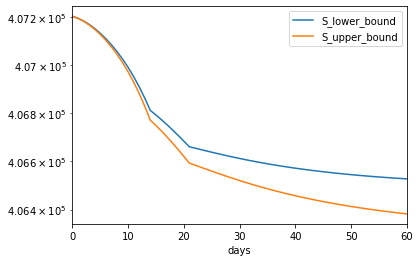

In [158]:
final.query('region_id == "AC RIO BRANCO"')\
.query('isolation_t == 14').query('lockdown_t == 21').set_index('days')\
[['S_lower_bound', 'S_upper_bound']].plot(logy=True)

In [84]:
(15 - 10 + 1. / 15 * 10) / 0.2 

28.333333333333332

In [45]:
ids = [region_id
         for region_id in 
         df.query('state in ("BA")')['region_id'].unique()
        ]

In [53]:
ids = [ids[3]]

In [54]:
break_list_in_chuncks = lambda data, chunck: [data[x:x+chunck] for x in range(0, len(data), chunck)]

In [55]:
for ch in break_list_in_chuncks(ids, 50):
    
    f = pd.concat([pd.read_csv(TREAT_PATH / 'cities' / (region_id + '.csv'))
                     for region_id in ch ])
    to_gbq(f, 'model_evolution', if_exists='append')


0it [00:00, ?it/s]
1it [00:15, 15.26s/it]


In [83]:
(15 - 10 * (1 + 1./15)) / 0.2

21.666666666666668

In [ ]:
(I1 - I0 + gamma * I0) / sigma

In [99]:
I1 = 13
I0 = 10
gamma = 1./15
sigma = 0.2

In [100]:
(I1 - I0 * (1 + gamma)) / sigma

11.66666666666667

In [103]:
(I1 - gamma) * I0 / sigma 

646.6666666666666

In [ ]:
I1 - I0 = sigma * E0 - gamma * I0

In [ ]:
( I1 - I0 + I0 * gamma) / sigma
( I1 - I0 (1  + gamma) ) / sigma

In [ ]:
(I1 - I0 (1 + gamma)) / sigma

In [ ]:
E0 = (I0 / sigma) * (I1 + gamma) 

In [ ]:
I1 / I0 ~ 1.33

In [ ]:
I1 / 1.33 = I0 

In [95]:
I0 = I1 / 1.33

In [96]:
I0

11.278195488721805

In [101]:
(I1 - I0 * (1 + gamma)) / sigma

11.66666666666667